In [134]:
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
import contextily as cx
import numpy as np
import joblib
import math
from pyrosm import OSM, get_data

from osmium.geom import haversine_distance
import osmium

In [135]:
osm_fp = "./openstreetmap data/porto.osm.pbf"
osm = OSM(osm_fp)

# Parse roads that can be driven by car
# roads = osm.get_network(network_type="driving")
# roads.plot(figsize=(10,10))

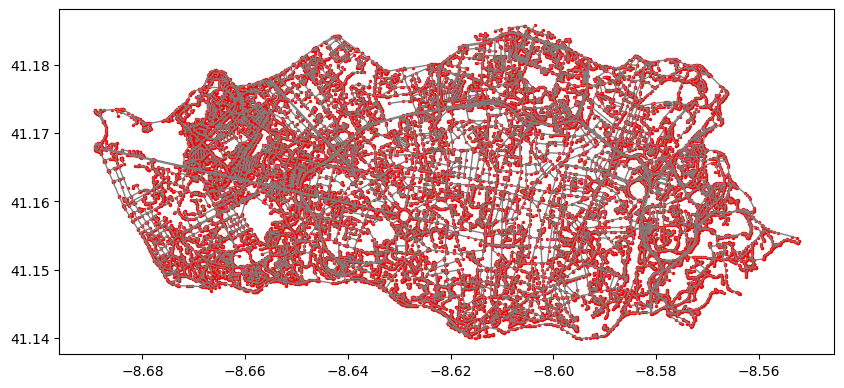

In [136]:
# Parse nodes and edges
road_nodes, road_edges = osm.get_network(network_type="driving", nodes=True)

# Plot the data
ax = road_edges.plot(figsize=(10,10), color="gray", lw=1.0)
ax = road_nodes.plot(ax=ax, color="red", markersize=2)

In [137]:
data_folder = "./openstreetmap data/"
stcp_nodes = gpd.read_file(data_folder + "stcp_nodes.gpkg")
stcp_edges = gpd.read_file(data_folder + "stcp_edges.gpkg")
metro_nodes = gpd.read_file(data_folder + "metro_nodes.gpkg")
metro_edges = gpd.read_file(data_folder + "metro_edges.gpkg")

stcp_nodes.crs = "EPSG:4326"
stcp_edges.crs = "EPSG:4326"
metro_edges.crs = "EPSG:4326"
metro_nodes.crs = "EPSG:4326"

G = osm.to_graph(stcp_nodes, stcp_edges, graph_type="networkx")

In [138]:
type(stcp_nodes)

geopandas.geodataframe.GeoDataFrame

In [139]:
# metro_edges u and v as string
# metro_edges['u'] = metro_edges['u'].astype(str)
# metro_edges['v'] = metro_edges['v'].astype(str)

In [140]:
# metro_nodes
# metro_nodes['id'] = metro_nodes['id'].astype(str)

Add metro nodes and edges to the bus graph

In [141]:
for metro_node in metro_nodes.to_dict(orient='records'):
    G.add_node(metro_node['id'], timestamp=metro_node['timestamp'], tags=metro_node['tags'], visible=metro_node['visible'], version=metro_node['version'], x=metro_node['lon'], y=metro_node['lat'], changeset=metro_node['changeset'], geometry=metro_node['geometry'])

In [142]:
# check for edges that use u and v that do not exist in metro_nodes
metro_nodes_ids = metro_nodes['id'].values
metro_edges = metro_edges[metro_edges['u'].isin(metro_nodes_ids) & metro_edges['v'].isin(metro_nodes_ids)]


In [143]:
# # add metro edges
for _, edge in metro_edges.iterrows():
    G.add_edge(edge['u'], edge['v'], length=edge['length'], mode='metro')
    G.add_edge(edge['v'], edge['u'], length=edge['length'], mode='metro')

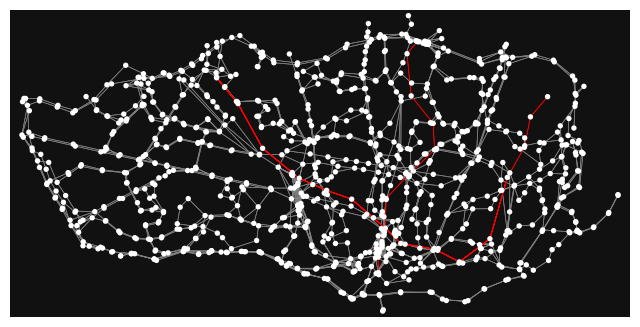

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [144]:
# edges red if metro
ox.plot_graph(G, edge_color=['red' if 'metro' in d.get('mode') else 'gray' for u,v,d in G.edges(data=True)], edge_linewidth=0.5)


# Path example

In [145]:
# Origin
orig_address = "Av. da Boavista 604-610, 4149-071 Porto"
orig_y, orig_x = ox.geocode(orig_address)  # notice the coordinate order (y, x)!

# Destination
dest_address = "Rua D. Frei Vicente da Soledade e Castro, Porto"
dest_y, dest_x = ox.geocode(dest_address) 

print("Origin coords:", orig_x, orig_y)
print("Destination coords:", dest_x, dest_y)

Origin coords: -8.63065 41.1585419
Destination coords: -8.5982521 41.17761


In [146]:
# 1. Find the closest nodes for origin and destination
orig_node_id, dist_to_orig = ox.distance.nearest_nodes(G, X=orig_x, Y=orig_y, return_dist=True)
dest_node_id, dist_to_dest = ox.distance.nearest_nodes(G, X=dest_x, Y=dest_y, return_dist=True)

print("Origin node-id:", orig_node_id, "and distance:", dist_to_orig, "meters.")
print("Destination node-id:", dest_node_id, "and distance:", dist_to_dest, "meters.")

Origin node-id: BCM4 and distance: 59.825321219958646 meters.
Destination node-id: FEUP2 and distance: 169.04204911132285 meters.


In [147]:
# Calculate the paths
metric_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='length')
time_path = nx.dijkstra_path(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

# Get also the actual travel times (summarize)
travel_length = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='length')
travel_time = nx.dijkstra_path_length(G, source=orig_node_id, target=dest_node_id, weight='travel_time_seconds')

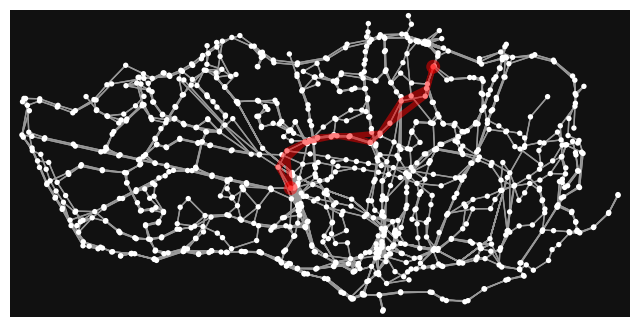

Text(0.5, 213.07593970246575, 'Shortest path distance  4383.0 meters.')

In [148]:
fig, ax = ox.plot_graph_route(G, metric_path)  # ou time_path

# Add the travel time as title
ax.set_xlabel("Shortest path distance {t: .1f} meters.".format(t=travel_length))

In [149]:
ox.plot_route_folium(G, metric_path)  # visualização diferente da mesma coisa


C:\Users\diogo\AppData\Local\Temp\ipykernel_22104\1075752465.py:1: FutureWarning: The `folium` module has been deprecated and will be removed in the v2.0.0 release. You can generate and explore interactive web maps of graph nodes, edges, and/or routes automatically using GeoPandas.GeoDataFrame.explore instead, for example like: `ox.graph_to_gdfs(G, nodes=False).explore()`. See the OSMnx examples gallery for complete details and demonstrations.
  ox.plot_route_folium(G, metric_path)  # visualização diferente da mesma coisa


# Statistical sections/sectors

In [150]:
sections = gpd.read_file(data_folder + "sections.gpkg")
# sections.crs = "EPSG:4326"

# sections.geometry = sections.geometry.centroid
# rename column DTMNFRSEC21 to id
sections.rename(columns={'DTMNFRSEC21': 'id'}, inplace=True)

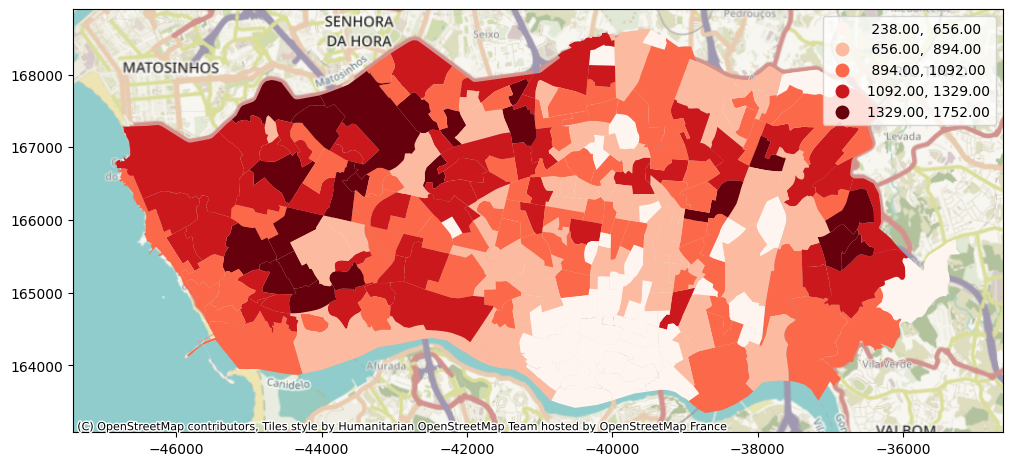

In [151]:
ax = sections.plot("N_INDIVIDUOS", scheme="natural_breaks", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)
cx.add_basemap(ax, crs=sections.crs)

In [152]:
# matrix = pd.DataFrame({'from_id': sections['id'].values.repeat(len(sections)), 'to_id': np.tile(sections['id'].values, len(sections))})
# ...

matrix = joblib.load(data_folder + 'matrix.pkl')

In [153]:
matrix

,from_id,to_id,metric_path,metric_path2
0,131217050,131217050,None,None
1,131217050,131217049,"[PISC, BSB, BCG]","[PISC, BSB, BCG]"
2,131217050,131203025,"[PISC, AQL1, FG1, MPL7, TXP1, SCR1, MAV2, IANT...","[PISC, AQL1, FG1, MPL7, TXP1, SCR1, MAV2, IANT..."
3,131217050,131203017,"[PISC, AQL1, FG1, MPL7, TXP1, SCR1, MAV2, IANT...","[PISC, AQL1, FG1, MPL7, TXP1, SCR1, MAV2, IANT..."
4,131217050,131217028,"[PISC, BSB, BCG, SP]","[PISC, BSB, BCG, SP]"
...,...,...,...,...
59044,131202012,131202001,"[BFM4, C24A5, DJOA4, BLM, MCBL3, PRDJ, AL3, MS...","[BFM4, C24A5, DJOA4, BLM, MCBL3, PRDJ, AL3, MS..."
59045,131202012,131217017,"[BFM4, C24A5, DJOA4, BLM, BLFZ1, JN3, TRD5]","[BFM4, C24A5, DJOA4, BLM, BLFZ1, JN3, TRD5]"
59046,131202012,131211033,"[BFM4, C24A5, DJOA4, BLM, BLFZ1, JN3, PRR1, FI...","[BFM4, C24A5, DJOA4, BLM, BLFZ1, JN3, PRR1, FI..."
59047,131202012,131202014,"[BFM4, C24A5, DJOA4, RFZ1, MOR2, ESCN2]","[BFM4, C24A5, DJOA4, RFZ1, MOR2, ESCN2]"


metric_path é de ter corrido o djikstra entre todos os nós e guardado o caminho mais curto entre cada par de nós (demorou 6 horas e o topo da rede estava cortada/interrompida)

metric_path2 é de ter corrido o floyd_warshall e guardado o caminho mais curto entre cada par de nós
(demorou menos de 10 minutos)

In [154]:
sections_nearest = sections.copy()
sections_nearest['nearest_node'] = sections.apply(lambda x: ox.distance.nearest_nodes(G, x.geometry.centroid.x, x.geometry.centroid.y), axis=1)

In [155]:
# demora uns 5 min a correr

floyd_predecessors, floyd_distances = nx.floyd_warshall_predecessor_and_distance(G, weight='length')

## Create Walking Edges on Current Network

In [156]:

# Create a copy of the original graph to preserve it
G_with_walking = G.copy()

# Count original edges
original_edges = G.number_of_edges()

# Maximum walking distance in meters
MAX_WALKING_DISTANCE = 300
WALKING_SPEED = 1.2  # meters per second (about 5 km/h)

# Get node positions
node_positions = {node: (data['y'], data['x'])  # (lat, lon)
                 for node, data in G.nodes(data=True)}

# Add a progress counter
total_nodes = len(G.nodes())
processed_nodes = 0
walking_edges_added = 0

for node1 in G.nodes():
    pos1 = node_positions[node1]  # (lat, lon)

    for node2 in G.nodes():
        if node1 != node2:
            pos2 = node_positions[node2]  # (lat, lon)

            # Calculate actual distance in meters
            # first convert pos1 and pos2 to osmium geom.Coordinates
            pos1_ = osmium.geom.Coordinates(pos1[1], pos1[0])
            pos2_ = osmium.geom.Coordinates(pos2[1], pos2[0])
            distance = haversine_distance(pos1_, pos2_)

            if distance <= MAX_WALKING_DISTANCE and not G_with_walking.has_edge(node1, node2):
                G_with_walking.add_edge(node1, node2,
                                      length=distance,
                                      travel_time_seconds=distance/WALKING_SPEED,
                                      mode='walking')
                walking_edges_added += 1

final_edges = G_with_walking.number_of_edges()

print(f"Walking edges added: {walking_edges_added}")
print(f"Total edges in new network: {final_edges}")
print(f"Percentage increase: {((final_edges/original_edges) - 1)*100:.1f}%")

Walking edges added: 6110
Total edges in new network: 8782
Percentage increase: 228.7%


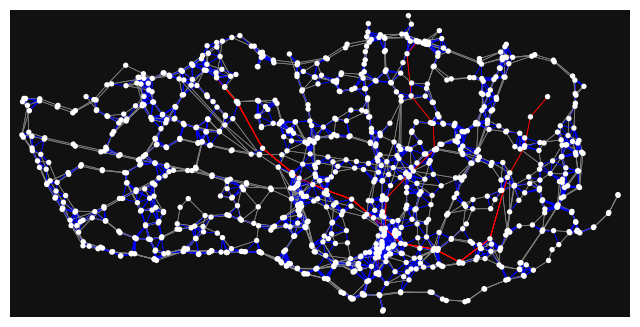

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [157]:
# Visualization
ox.plot_graph(G_with_walking,
              edge_color=['blue' if d.get('mode')=='walking' else 'red' if d.get('mode')=='metro' else 'gray' for u,v,d in G_with_walking.edges(data=True)],
              edge_linewidth=0.5)

## Join Metro with nearest Bus node (4 edges added because walking edges already got most of them)

In [158]:
# for all nodes in the metro network, find the nearest node in the bus network and add a walking edge
G_metro_connected = G_with_walking.copy()
# without all metro nodes
G_without_metro = G.copy()
G_without_metro.remove_nodes_from(metro_nodes['id'].values)
new_edge_counter = 0
for _, metro_node in metro_nodes.iterrows():
    # get G with metro_node dropped
    # G_ = G_metro_connected.copy()
    # G_.remove_node(metro_node['id'])
    nearest_node, dist = ox.distance.nearest_nodes(G_without_metro, X=metro_node['lon'], Y=metro_node['lat'], return_dist=True)
    # compute haversine distance
    pos1 = (metro_node['lat'], metro_node['lon'])
    pos2 = (G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x'])
    pos1_ = osmium.geom.Coordinates(pos1[1], pos1[0])
    pos2_ = osmium.geom.Coordinates(pos2[1], pos2[0])
    h_dist = haversine_distance(pos1_, pos2_)
    # print(f"Nearest node: {nearest_node}, distance: {dist}, haversine_distance: {h_dist}")
    
    if not G_metro_connected.has_edge(nearest_node, metro_node['id']):
        G_metro_connected.add_edge(nearest_node, metro_node['id'], length=h_dist, travel_time_seconds=h_dist/WALKING_SPEED, mode='walking', tag='metro_nearest_bus')
        new_edge_counter += 1
    if not G_metro_connected.has_edge(metro_node['id'], nearest_node):  
        G_metro_connected.add_edge(metro_node['id'], nearest_node, length=h_dist, travel_time_seconds=h_dist/WALKING_SPEED, mode='walking', tag='metro_nearest_bus')
        new_edge_counter += 1

In [159]:
new_edge_counter

4

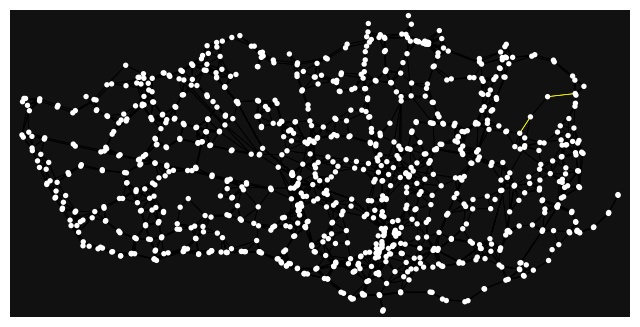

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [160]:
# plot
ox.plot_graph(G_metro_connected, edge_color=['yellow' if d.get('tag') == 'metro_nearest_bus' else 'black' if d.get('mode')=='walking' else 'black' if d.get('mode')=='metro' else 'black' for u,v,d in G_metro_connected.edges(data=True)], edge_linewidth=0.5)


## Join Bus with nearest Metro node (474 edges added)

In [161]:
MAX_WALKING_DISTANCE_TO_METRO = 1000

# for all nodes in the bus network, find the nearest node in the metro network and add a walking edge if the distance is less than 1000 meters
G_bus_connected = G_metro_connected.copy()
# without all bus nodes
G_without_bus = G.copy()
G_without_bus.remove_nodes_from(stcp_nodes['id'].values)
new_edge_counter = 0
for _, bus_node in stcp_nodes.iterrows():
    # get G with bus_node dropped
    # G_ = G_bus_connected.copy()
    # G_.remove_node(bus_node['id'])
    nearest_node, dist = ox.distance.nearest_nodes(G_without_bus, X=bus_node['lon'], Y=bus_node['lat'], return_dist=True)
    # compute haversine distance
    pos1 = (bus_node['lat'], bus_node['lon'])
    pos2 = (G.nodes[nearest_node]['y'], G.nodes[nearest_node]['x'])
    pos1_ = osmium.geom.Coordinates(pos1[1], pos1[0])
    pos2_ = osmium.geom.Coordinates(pos2[1], pos2[0])
    h_dist = haversine_distance(pos1_, pos2_)
    # print(f"Nearest node: {nearest_node}, distance: {dist}, haversine_distance: {h_dist}")
    if h_dist > MAX_WALKING_DISTANCE_TO_METRO or G_bus_connected.has_edge(bus_node['id'], nearest_node): # this is not the MAX_WALKING_DISTANCE used previously because people may be willing to walk more to get to a metro station
        continue
    new_edge_counter += 1
    
    # check if such edge alreafy exists
    G_bus_connected.add_edge(bus_node['id'], nearest_node, length=h_dist, travel_time_seconds=h_dist/WALKING_SPEED, mode='walking', tag='bus_nearest_metro')
    
    if h_dist > MAX_WALKING_DISTANCE or G_bus_connected.has_edge(nearest_node, bus_node['id']):  # walking from the metro to a "random" bus stop is not as desirable
        continue
    
    new_edge_counter += 1
    G_bus_connected.add_edge(nearest_node, bus_node['id'], length=h_dist, travel_time_seconds=h_dist/WALKING_SPEED, mode='walking', tag='bus_nearest_metro')

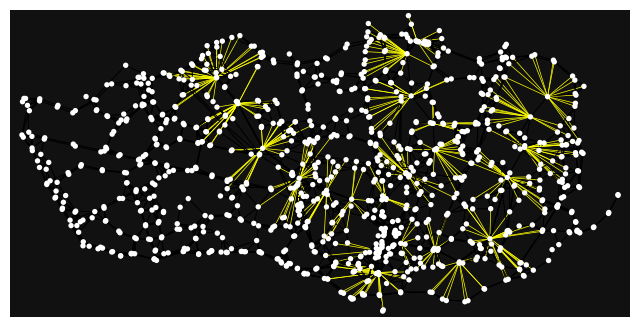

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [162]:
# plot
ox.plot_graph(G_bus_connected, edge_color=['yellow' if d.get('tag') == 'bus_nearest_metro' else 'black' if d.get('mode')=='walking' else 'black' if d.get('mode')=='metro' else 'black' for u,v,d in G_bus_connected.edges(data=True)], edge_linewidth=0.5)

In [163]:
new_edge_counter

451

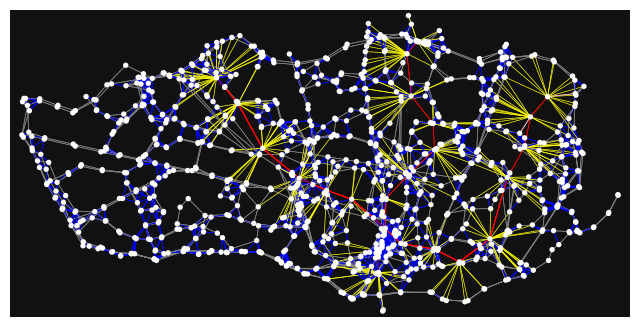

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [164]:
# plot every type of edge
ox.plot_graph(G_bus_connected, edge_color=['yellow' if d.get('tag') == 'bus_nearest_metro' else 'pink' if d.get('tag') == 'metro_nearest_bus' else 'blue' if d.get('mode')=='walking' else 'red' if d.get('mode')=='metro' else 'gray' for u,v,d in G_bus_connected.edges(data=True)], edge_linewidth=0.5)

In [165]:
# store the graph nodes and edges as gpkg
gdf_nodes = ox.graph_to_gdfs(G_bus_connected, edges=False)
gdf_edges = ox.graph_to_gdfs(G_bus_connected, nodes=False)

In [166]:
# some nodes have NaN osmid (the metro nodes)
i=1
for idx, row in gdf_nodes.iterrows():
    if not type(row['osmid']) == str:
        i+=1
        gdf_nodes.at[idx, 'osmid'] = idx

In [167]:
gdf_nodes['osmid'].isna().sum()


0

In [168]:
gdf_nodes['osmid'].duplicated().sum()

0

In [169]:
# column osmid is duplicated, rename the index column
gdf_nodes.rename(columns={'osmid': 'id'}, inplace=True)

In [170]:
gdf_nodes.to_file(data_folder + "porto_nodes.gpkg", driver="GPKG")
gdf_edges.to_file(data_folder + "porto_edges.gpkg", driver="GPKG")




In [171]:
gdf_nodes

,id,timestamp,tags,visible,version,x,y,changeset,geometry
osmid,,,,,,,,,
1ADA1,1ADA1,2024-11-16 14:31:45.227,bus,True,1,-8.613556,41.171644,1,POINT (-8.61356 41.17164)
1AL2,1AL2,2024-11-16 14:31:45.227,bus,True,1,-8.610069,41.149515,1,POINT (-8.61007 41.14951)
1AL6,1AL6,2024-11-16 14:31:45.227,bus,True,1,-8.610010,41.149118,1,POINT (-8.61001 41.14912)
1BS2,1BS2,2024-11-16 14:31:45.227,bus,True,1,-8.627762,41.155925,1,POINT (-8.62776 41.15593)
1BS3,1BS3,2024-11-16 14:31:45.227,bus,True,1,-8.628206,41.154471,1,POINT (-8.62821 41.15447)
...,...,...,...,...,...,...,...,...,...
5775,5775,2024-11-16 14:13:07.127,metro,True,1,-8.604272,41.161120,1,POINT (-8.60427 41.16112)
5776,5776,2024-11-16 14:13:07.127,metro,True,1,-8.603607,41.174250,1,POINT (-8.60361 41.17425)
5777,5777,2024-11-16 14:13:07.127,metro,True,1,-8.598744,41.169690,1,POINT (-8.59874 41.16969)


In [172]:
# load the graph
porto_nodes = gpd.read_file(data_folder + "porto_nodes.gpkg")
porto_edges = gpd.read_file(data_folder + "porto_edges.gpkg")


G = osm.to_graph(porto_nodes, porto_edges, graph_type='networkx', node_id_col='osmid')

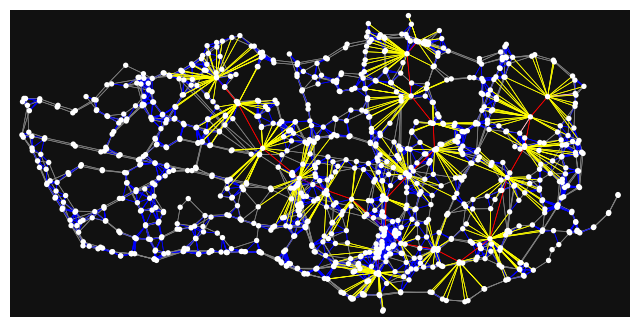

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [173]:
ox.plot_graph(G, edge_color=['yellow' if d.get('tag') == 'bus_nearest_metro' else 'pink' if d.get('tag') == 'metro_nearest_bus' else 'blue' if d.get('mode')=='walking' else 'red' if d.get('mode')=='metro' else 'gray' for u,v,d in G.edges(data=True)], edge_linewidth=0.5)

In [174]:
porto_edges

,u,v,key,mode,access,area,bicycle,bridge,busway,cycleway,...,width,osmid,timestamp,version,tags,osm_type,length,travel_time_seconds,tag,geometry
0,1ADA1,CI31,0,704_0,None,None,None,None,None,None,...,None,704_0:i,2024-11-16T14:50:22.000999,1.0,None,way,254.108329,NaN,None,"LINESTRING (-8.61356 41.17164, -8.61319 41.17392)"
1,1ADA1,1R9A1,0,704_0,None,None,None,None,None,None,...,None,704_0:i,2024-11-16T14:50:21.938000,1.0,None,way,398.813629,NaN,None,"LINESTRING (-8.61786 41.17012, -8.61356 41.17164)"
2,1ADA1,ADA2,0,walking,None,None,None,None,None,None,...,None,None,None,NaN,None,None,81.478113,67.898428,None,"LINESTRING (-8.61356 41.17164, -8.61448 41.17188)"
3,1ADA1,ADA3,0,walking,None,None,None,None,None,None,...,None,None,None,NaN,None,None,113.531265,94.609388,None,"LINESTRING (-8.61356 41.17164, -8.61296 41.17073)"
4,1ADA1,ADA4,0,walking,None,None,None,None,None,None,...,None,None,None,NaN,None,None,116.676918,97.230765,None,"LINESTRING (-8.61356 41.17164, -8.61274 41.17079)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9232,5791,HSJ7,0,walking,None,None,None,None,None,None,...,None,None,None,NaN,None,None,167.226248,139.355206,None,"LINESTRING (-8.60224 41.18326, -8.60032 41.18284)"
9233,5791,HSJ8,0,walking,None,None,None,None,None,None,...,None,None,None,NaN,None,None,191.604402,159.670335,None,"LINESTRING (-8.60224 41.18326, -8.60001 41.18286)"
9234,5791,HSJ9,0,walking,None,None,None,None,None,None,...,None,None,None,NaN,None,None,211.813830,176.511525,None,"LINESTRING (-8.60224 41.18326, -8.59978 41.18280)"
9235,5791,IPO2,0,walking,None,None,None,None,None,None,...,None,None,None,NaN,None,None,129.720037,108.100031,None,"LINESTRING (-8.60224 41.18326, -8.60379 41.18333)"


In [175]:
porto_nodes

,osmid,id,timestamp,tags,visible,version,x,y,changeset,geometry
0,1ADA1,1ADA1,2024-11-16 14:31:45.227,bus,True,1,-8.613556,41.171644,1,POINT (-8.61356 41.17164)
1,1AL2,1AL2,2024-11-16 14:31:45.227,bus,True,1,-8.610069,41.149515,1,POINT (-8.61007 41.14951)
2,1AL6,1AL6,2024-11-16 14:31:45.227,bus,True,1,-8.610010,41.149118,1,POINT (-8.61001 41.14912)
3,1BS2,1BS2,2024-11-16 14:31:45.227,bus,True,1,-8.627762,41.155925,1,POINT (-8.62776 41.15593)
4,1BS3,1BS3,2024-11-16 14:31:45.227,bus,True,1,-8.628206,41.154471,1,POINT (-8.62821 41.15447)
...,...,...,...,...,...,...,...,...,...,...
1000,5775,5775,2024-11-16 14:13:07.127,metro,True,1,-8.604272,41.161120,1,POINT (-8.60427 41.16112)
1001,5776,5776,2024-11-16 14:13:07.127,metro,True,1,-8.603607,41.174250,1,POINT (-8.60361 41.17425)
1002,5777,5777,2024-11-16 14:13:07.127,metro,True,1,-8.598744,41.169690,1,POINT (-8.59874 41.16969)
1003,5778,5778,2024-11-16 14:13:07.127,metro,True,1,-8.610815,41.144940,1,POINT (-8.61082 41.14494)
